### Set up water network model

In this example, we test our quantum solvers into a slightly larger network as contained in `Net1Loops.inp`. Let's start by setting up the model:

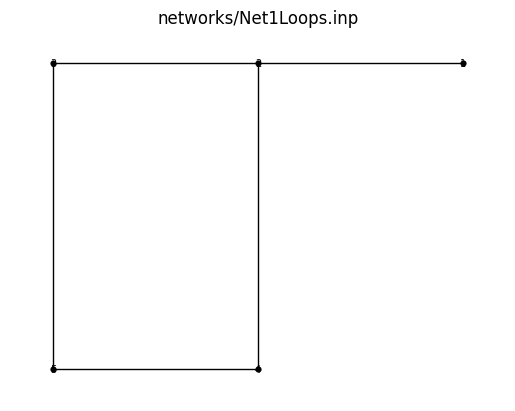

<Axes: title={'center': 'networks/Net1Loops.inp'}>

In [1]:
import os
import wntr
import wntr_quantum

os.environ["EPANET_TMP"] = "/home/nico/.epanet_quantum"
os.environ["EPANET_QUANTUM"] = "/home/nico/QuantumApplicationLab/vitens/EPANET"

# set up network model
inp_file = 'networks/Net1Loops.inp'
wn = wntr.network.WaterNetworkModel(inp_file)

# plot network
wntr.graphics.plot_network(wn, title=wn.name, node_labels=True)

# print options
# dict(wn.options.hydraulic)

### Solve model using the classical WNTR simulator

For comparison, we will start with by solving the network model with the classical WNTR simulator.

In [2]:
# define the classical WNTR simulator
sim = wntr.sim.WNTRSimulator(wn)

# run WNTR simulator
results_wntr = sim.run_sim()

# set A and b matrices
wntr_A = sim._model.evaluate_jacobian()
wntr_b = sim._model.evaluate_residuals()

# set the size of the Jacobian (A matrix)
wntr_A_dim = wntr_A.shape[0]
print(f"Size of the Jacobian in WNTR simulator: {wntr_A_dim}")
print(f"Size of the b vector in WNTR simulator: {wntr_b.shape[0]}")

results_wntr.node["pressure"], results_wntr.link["flowrate"]

Size of the Jacobian in WNTR simulator: 9
Size of the b vector in WNTR simulator: 9


(          2          3          4          5    1
 0  57.93989  31.496198  52.434498  21.174181  0.0,
          1         2         3         4         5
 0  0.16387  0.059455  0.076645  0.043315  0.031685)

### Solve model using the classical Epanet simulator

We now solve the same problem using the classical Epanet simulator. Note that, by default, `QuantumEpanetSimulator` uses a classical `CholeskySolver` to iteratively solve the linear problem.

In [3]:
import sys

# define the classical EPANET simulator
sim = wntr_quantum.sim.QuantumEpanetSimulator(wn)

# run the EPANET simulation
results_epanet = sim.run_sim()

# remember to set up EPANET Quantum environment variables!
epanet_path = os.environ["EPANET_QUANTUM"]
epanet_tmp = os.environ["EPANET_TMP"]

# check paths
print(f"Your EPANET quantum path: {epanet_path}")
print(f"Your EPANET temp dir: {epanet_tmp}\n")

util_path = os.path.join(epanet_path, 'src/py/')
sys.path.append(util_path)

from quantum_linsolve import load_json_data
epanet_A, epanet_b = load_json_data(os.path.join(epanet_tmp,'smat.json'))

# set the size of the Jacobian (A matrix)
epanet_A_dim = epanet_A.todense().shape[0]
print(f"Size of the Jacobian in EPANET simulator: {epanet_A_dim}")
print(f"Size of the b vector in EPANET simulator: {epanet_b.shape[0]}")

# save number of nodes and pipes
n_nodes = len(results_epanet.node["pressure"].iloc[0]), 
n_pipes = len(results_epanet.link["flowrate"].iloc[0])

results_epanet.node["pressure"], results_epanet.link["flowrate"]

/home/nico/QuantumApplicationLab/vitens/wntr-quantum/wntr_quantum/epanet/Linux/libepanet22_amd64.so
Your EPANET quantum path: /home/nico/QuantumApplicationLab/vitens/EPANET
Your EPANET temp dir: /home/nico/.epanet_quantum

Size of the Jacobian in EPANET simulator: 4
Size of the b vector in EPANET simulator: 4


(name          2          3          4          5             1
 0     57.939995  31.496479  52.434612  21.174667  4.394531e-07,
 name         1         2         3         4         5
 0     0.163867  0.059455  0.076645  0.043315  0.031685)

### Define a helper function

This function checks that the quantum results are within `TOL`% of those obtained classically. It also fills in lists containing the final values of pressures and flow rates obtained.

In [4]:
TOL = 5  # => per cent
DELTA = 1.0e-12

classical_res = []
quantum_res = []


def compare_results(classical_result, quantum_result):
    """
    Helper function that compares the classical and quantum simulation results.
    """
    def calculate_differences(classical_value, quantum_value):
        """Helper function to evaluate percentage difference between classical and quantum results."""
        is_close_to_classical = abs(classical_value - quantum_value) / abs(classical_value + DELTA) <= TOL / 100.0
        if is_close_to_classical:
            print(f"Quantum result {quantum_value} within {TOL}% of classical result {classical_value}")
            quantum_res.append(quantum_value)
            classical_res.append(classical_value)
        return is_close_to_classical
    
    for link in classical_result.link["flowrate"].columns:
        classical_value = classical_result.link["flowrate"][link].iloc[0]
        quantum_value = quantum_result.link["flowrate"][link].iloc[0]
        message = f"Flowrate {link}: {quantum_value} not within {TOL}% of classical result {classical_value}"
        assert calculate_differences(classical_value, quantum_value), message

    for node in classical_result.node["pressure"].columns:
        classical_value = classical_result.node["pressure"][node].iloc[0]
        quantum_value = quantum_result.node["pressure"][node].iloc[0]
        message= f"Pressure {node}: {quantum_value} not within {TOL}% of classical result {classical_value}"
        assert calculate_differences(classical_value, quantum_value), message

### Solve model using QUBO solver (with daptative encoding)

Finally, we solve the problem once again but now using the QUBO quantum linear solver. The results are validated using the `compare_results` helper function defined above.

In [5]:

from quantum_newton_raphson.qubo_solver import QUBO_SOLVER
from qubols.encodings import RangedEfficientEncoding

linear_solver = QUBO_SOLVER(
        encoding=RangedEfficientEncoding,
        num_qbits=15,
        num_reads=100,
        range=200,
        offset=600,
        iterations=5,
        temperature=1e4,
        use_aequbols=True,
)

sim = wntr_quantum.sim.QuantumEpanetSimulator(wn, linear_solver=linear_solver)
results_qubos = sim.run_sim(linear_solver=linear_solver)

# check that the results are within a certain tolerance from the classical epanet
compare_results(results_epanet, results_qubos)

{'encoding': <class 'qubols.encodings.RangedEfficientEncoding'>, 'num_qbits': 15, 'num_reads': 100, 'range': 200, 'offset': 600, 'iterations': 5, 'temperature': 10000.0}
/home/nico/QuantumApplicationLab/vitens/wntr-quantum/wntr_quantum/epanet/Linux/libepanet22_amd64.so
0 [600, 600, 600, 600] 200
1 [653.1282426905939, 675.0045779161326, 685.7962522126595, 684.3679423792956] [162.19783659021755, 147.89105361858333, 42.720160646958185, 63.89584840114656]
2 [644.009997711067, 666.5642351746703, 685.0869875055868, 683.5021132671028] [75.45597702856479, 50.57205374895429, 10.046036109323007, 15.040310664376154]
3 [644.0140024853814, 666.5516469026392, 685.076977352827, 683.4870178369654] [19.896996994125942, 13.32363024990175, 2.6333150952487467, 3.931600327637771]
4 [643.992959499734, 666.5427107763383, 685.0757495165467, 683.4848733908677] [5.223353430776938, 3.5236692804443814, 0.7094092503981015, 1.0570316100466943]
0 [600, 600, 600, 600] 200
1 [529.6832082036257, 599.9877922236465, 681.

### Plot pressures and flow rates

Let's check graphically the equivalence of the results.

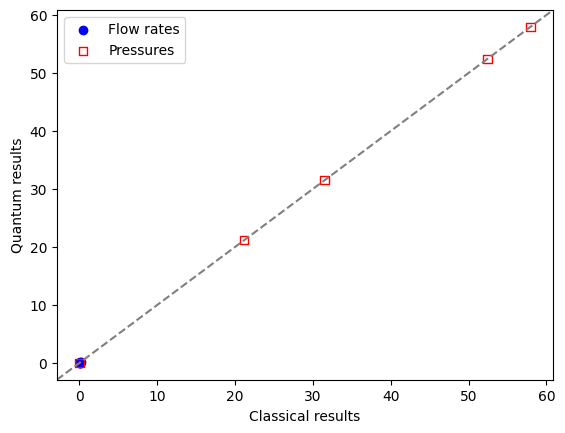

In [6]:
import matplotlib.pyplot as plt
plt.scatter(classical_res[:n_pipes], quantum_res[:n_pipes], label="Flow rates", color="blue", marker="o")
plt.scatter(classical_res[n_pipes:], quantum_res[n_pipes:], label="Pressures", color="red", marker="s", facecolors='none')
plt.axline((0, 0), slope=1, linestyle="--", color="gray", label="")
plt.xlabel("Classical results")
plt.ylabel("Quantum results")
plt.legend()
plt.show()